In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.ImageFolder(root="/kaggle/input/lgcancer/data",transform=transform)

train_size = int(0.8 * len(dataset))
test_size = int(0.2 * len(dataset))

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

In [4]:
class LungCancerCNN(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*2*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*2*2, out_channels=hidden_units*2*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*2*2, out_channels=hidden_units*2*2*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*2*2*2, out_channels=hidden_units*2*2*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*2*2*2, out_channels=hidden_units*2*2*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*2*2*2, out_channels=hidden_units*2*2*2*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*2*2*2*2, out_channels=hidden_units*2*2*2*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*2*2*2*2, out_channels=hidden_units*2*2*2*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.conv_block_5 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*2*2*2*2, out_channels=hidden_units*2*2*2*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*2*2*2*2, out_channels=hidden_units*2*2*2*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*2*2*2*2, out_channels=hidden_units*2*2*2*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*2*2*2*2*7*7, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096, out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.conv_block_4(x)
        x = self.conv_block_5(x)
        x = self.fc_layer(x)
        return x

In [5]:
model = LungCancerCNN(input_shape=3, hidden_units=32, output_shape=1)
model.to(device)
model = torch.compile(model)

In [6]:
from torch.optim.lr_scheduler import StepLR

loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In [7]:
def accuracy_fn(y_true, y_pred):
    return (y_true == y_pred).sum().item() / len(y_true) * 100

In [9]:
train_loss_history, train_acc_history = [], []
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    
    train_loss, train_acc = 0, 0
    model.train()

    for X, y in data_loader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()

        y_pred = model(X)

        loss = loss_fn(y_pred.squeeze(1), y.float())
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        pred_labels = (torch.sigmoid(y_pred) > 0.5).int().squeeze(1)
        accuracy = accuracy_fn(y_true=y, y_pred=pred_labels)
        train_acc += accuracy


    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    print(f"Training Loss: {train_loss:.5f} | Training Accuracy: {train_acc:.2f}%")


In [10]:
test_loss_history, test_acc_history = [], []
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    
    test_loss, test_acc = 0, 0

    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)

            loss = loss_fn(y_pred.squeeze(1), y.float())
            test_loss += loss.item()

            pred_labels = (torch.sigmoid(y_pred) > 0.5).int().squeeze(1)
            accuracy = accuracy_fn(y_true=y, y_pred=pred_labels)
            test_acc += accuracy

            

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        test_loss_history.append(test_loss)
        test_acc_history.append(test_acc)

    print(f"Testing Loss: {test_loss:.5f} | Testing Accuracy: {test_acc:.2f}%")

In [11]:
import numpy as np

In [12]:
EPOCHS = 10

for epoch in range(EPOCHS):
    train_step(model=model, data_loader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn, device=device)
    test_step(model=model, data_loader=train_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)
    scheduler.step()

torch.save(model, "test1.pt")
np.save("train_loss.npy", np.array(train_loss_history))
np.save("train_acc.npy", np.array(train_acc_history))
np.save("test_loss.npy", np.array(test_loss_history))
np.save("test_acc.npy", np.array(test_acc_history))

W0620 05:23:34.406000 35 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode


Training Loss: 0.12602 | Training Accuracy: 95.22%
Testing Loss: 0.05069 | Testing Accuracy: 97.91%
Training Loss: 0.07069 | Training Accuracy: 97.95%
Testing Loss: 0.04560 | Testing Accuracy: 98.79%
Training Loss: 0.05988 | Training Accuracy: 98.27%
Testing Loss: 0.04578 | Testing Accuracy: 98.41%
Training Loss: 0.03340 | Training Accuracy: 98.74%
Testing Loss: 0.02595 | Testing Accuracy: 99.01%
Training Loss: 0.02310 | Training Accuracy: 99.18%
Testing Loss: 0.01324 | Testing Accuracy: 99.49%
Training Loss: 0.01301 | Training Accuracy: 99.64%
Testing Loss: 0.00912 | Testing Accuracy: 99.76%
Training Loss: 0.00868 | Training Accuracy: 99.82%
Testing Loss: 0.00784 | Testing Accuracy: 99.86%
Training Loss: 0.00843 | Training Accuracy: 99.83%
Testing Loss: 0.00765 | Testing Accuracy: 99.83%
Training Loss: 0.00741 | Training Accuracy: 99.85%
Testing Loss: 0.00699 | Testing Accuracy: 99.88%
Training Loss: 0.00747 | Training Accuracy: 99.86%
Testing Loss: 0.00692 | Testing Accuracy: 99.85%


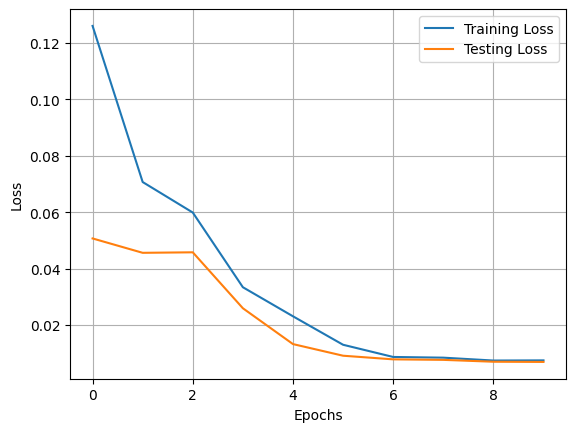

In [19]:
plt.plot(train_loss_history, label = "Training Loss")
plt.plot(test_loss_history, label = "Testing Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(axis = 'y')
plt.grid(axis = 'x')

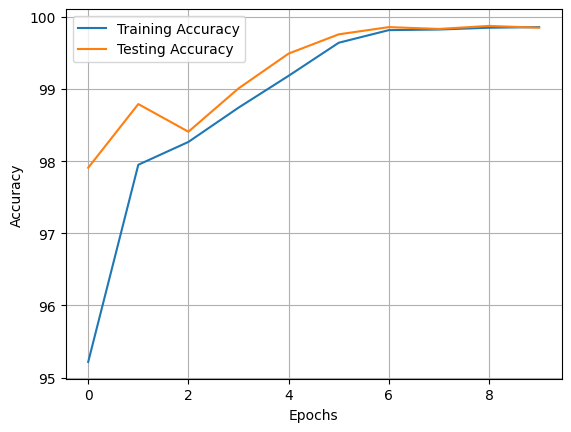

In [20]:
plt.plot(train_acc_history, label = "Training Accuracy")
plt.plot(test_acc_history, label = "Testing Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(axis = 'y')
plt.grid(axis = 'x')